<a href="https://colab.research.google.com/github/Chinh2702/KTLT_PYTHONG/blob/main/1_1_4_B%C3%A0i_t%E1%BA%ADp_th%E1%BB%B1c_h%C3%A0nh_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bước 1: Chuẩn bị môi trường và đọc dữ liệu

In [4]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [5]:
# pandas dùng để đọc file và thao tác dữ liệu
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
data = pd.read_csv("diabetes.csv")

# Xem vài dòng đầu tiên, kiểm tra cột có đúng không
print(data.head())

# Kiểm tra thông tin dữ liệu (kiểu biến, số lượng quan sát), cho biết kiểu dữ liệu (int, float) và có bị thiếu dữ liệu không.
print(data.info())

# Kiểm tra thống kê cơ bản, hiển thị trung bình, độ lệch chuẩn, min, max, và tứ phân vị (25%, 50%, 75%).
print(data.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

## Bước 2: Kiểm tra trùng lặp & các lỗi định dạng

In [10]:
## Kiểm tra và loại bỏ bản ghi trùng lặp nếu cần, gán lại DataFrame để tránh SettingWithCopyWarning.
# Số dòng trùng lặp (toàn hàng)
n_dup = data.duplicated().sum()
print("Số hàng duplicate:", n_dup)

# Nếu có, loại bỏ (nếu muốn)
if n_dup > 0:
    data = data.drop_duplicates().reset_index(drop=True)
    print("Đã drop duplicates, shape mới:", data.shape)

# Kiểm tra các cột text, ngày (nếu có) — ở bộ này thường không cần
print(data.dtypes)


Số hàng duplicate: 0
Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


## Bước 3: Kiểm tra và xử lý giá trị thiếu (missing values)

In [11]:
## Giải thích: nhiều dataset mã hóa giá trị thiếu bằng 0; ta chuyển 0 -> NaN để pandas và các hàm thống kê bỏ qua khi cần hoặc để xử lý missing một cách đúng đắn.

# Kiểm tra nhanh: số NaN hiện có thực sự (ô trống)
print("Missing (NaN) ban đầu theo cột:")
print(data.isnull().sum())

# Kiểm tra số lượng giá trị bằng 0 để thấy có bao nhiêu giá trị được mã hóa là 0 (thực chất là missing) là không hợp lệ y học
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    print(f"Số lượng giá trị 0 trong {col}: {int((data[col] == 0).sum())}")

# Thay giá trị 0 bằng NaN an toàn trên tập các cột được chỉ định (không dùng inplace trên slice); cú pháp này gán lại nguyên khối giúp tránh SettingWithCopyWarning
data[cols_with_zero] = data[cols_with_zero].replace(0, np.nan)

# Kiểm tra lại NaN thực sự (ô trống): giờ sẽ thấy NaN xuất hiện
print("\nSau khi thay 0 -> NaN, tổng NaN theo cột:")
print(data.isnull().sum())



Missing (NaN) ban đầu theo cột:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Số lượng giá trị 0 trong Glucose: 0
Số lượng giá trị 0 trong BloodPressure: 0
Số lượng giá trị 0 trong SkinThickness: 0
Số lượng giá trị 0 trong Insulin: 0
Số lượng giá trị 0 trong BMI: 0

Sau khi thay 0 -> NaN, tổng NaN theo cột:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Bước 4 — Tính thống kê mô tả bằng numpy và scipy.stats



In [12]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print("Numeric columns:", num_cols)

def descriptive_with_numpy_stats(arr):
    arr_clean = np.array(arr.dropna())   # convert thành numpy array, bỏ NaN
    res = {}
    if arr_clean.size == 0:
        return None
    res['n'] = arr_clean.size
    res['mean'] = np.mean(arr_clean)                           # numpy mean
    res['median'] = np.median(arr_clean)                       # numpy median
    # mode: scipy.stats.mode hoặc pandas Series.mode (pandas trả về list nếu multi-mode)
    mode_result = stats.mode(arr_clean, keepdims=True)         # mode có rtype ModeResult
    res['mode'] = mode_result.mode[0]                          # lấy mode (nếu nhiều mode, SciPy trả về nhỏ nhất)
    res['variance'] = np.var(arr_clean, ddof=1)               # sample variance (ddof=1)
    res['std'] = np.std(arr_clean, ddof=1)                    # sample std
    res['min'] = np.min(arr_clean)
    res['max'] = np.max(arr_clean)
    res['range'] = res['max'] - res['min']
    res['p60'] = np.percentile(arr_clean, 60)                 # 60th percentile ví dụ
    res['Q1'] = np.quantile(arr_clean, 0.25)
    res['Q2'] = np.quantile(arr_clean, 0.50)
    res['Q3'] = np.quantile(arr_clean, 0.75)
    res['IQR'] = stats.iqr(arr_clean)                         # scipy iqr (Q3-Q1)
    return res

# In mô tả cho từng biến numeric
for col in num_cols:
    stats_col = descriptive_with_numpy_stats(data[col])
    print("\n--- Variable:", col)
    if stats_col is None:
        print("Không có quan sát hợp lệ (sau dropna).")
        continue
    for k,v in stats_col.items():
        print(f"{k}: {v}")


Numeric columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

--- Variable: Pregnancies
n: 768
mean: 3.8450520833333335
median: 3.0
mode: 1
variance: 11.354056320621465
std: 3.3695780626988694
min: 0
max: 17
range: 17
p60: 4.0
Q1: 1.0
Q2: 3.0
Q3: 6.0
IQR: 5.0

--- Variable: Glucose
n: 763
mean: 121.6867627785059
median: 117.0
mode: 99.0
variance: 932.4253757271167
std: 30.535641072804033
min: 44.0
max: 199.0
range: 155.0
p60: 125.0
Q1: 99.0
Q2: 117.0
Q3: 141.0
IQR: 42.0

--- Variable: BloodPressure
n: 733
mean: 72.40518417462484
median: 72.0
mode: 70.0
variance: 153.31784194007707
std: 12.38215821010526
min: 24.0
max: 122.0
range: 98.0
p60: 75.0
Q1: 64.0
Q2: 72.0
Q3: 80.0
IQR: 16.0

--- Variable: SkinThickness
n: 541
mean: 29.153419593345657
median: 29.0
mode: 32.0
variance: 109.7671595810228
std: 10.476982369987208
min: 7.0
max: 99.0
range: 92.0
p60: 32.0
Q1: 22.0
Q2: 29.0
Q3: 36.0
IQR: 14.0

--- Variable

## Bước 5: Xử lý NaN trước khi tính mô tả

In [13]:
## Dùng phương pháp Impute theo median (đơn giản, an toàn cho mô tả),
## median imputation không bị kéo bởi extreme values, thường hợp lý cho thống kê mô tả
df_median = data.copy()
for col in cols_with_zero:
    med = df_median[col].median()    # pandas median bỏ NaN
    df_median[col] = df_median[col].fillna(med)
print("Số NaN còn lại (median impute):", df_median.isnull().sum().sum())


Số NaN còn lại (median impute): 0


## Bước 6: Trực quan hóa dữ liệu (Boxplot và Histogram)

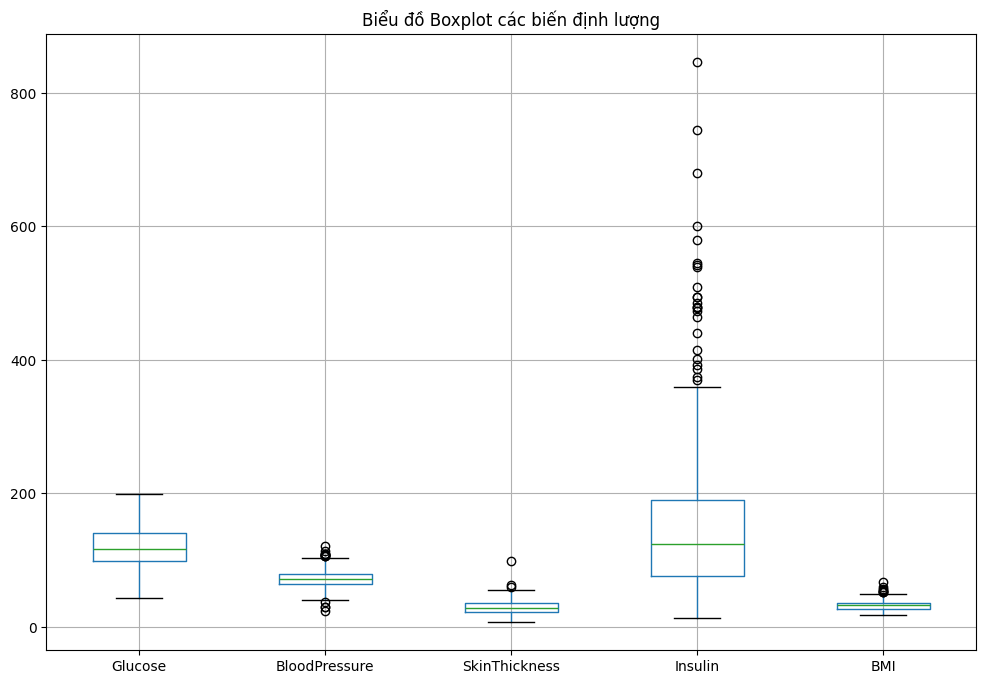

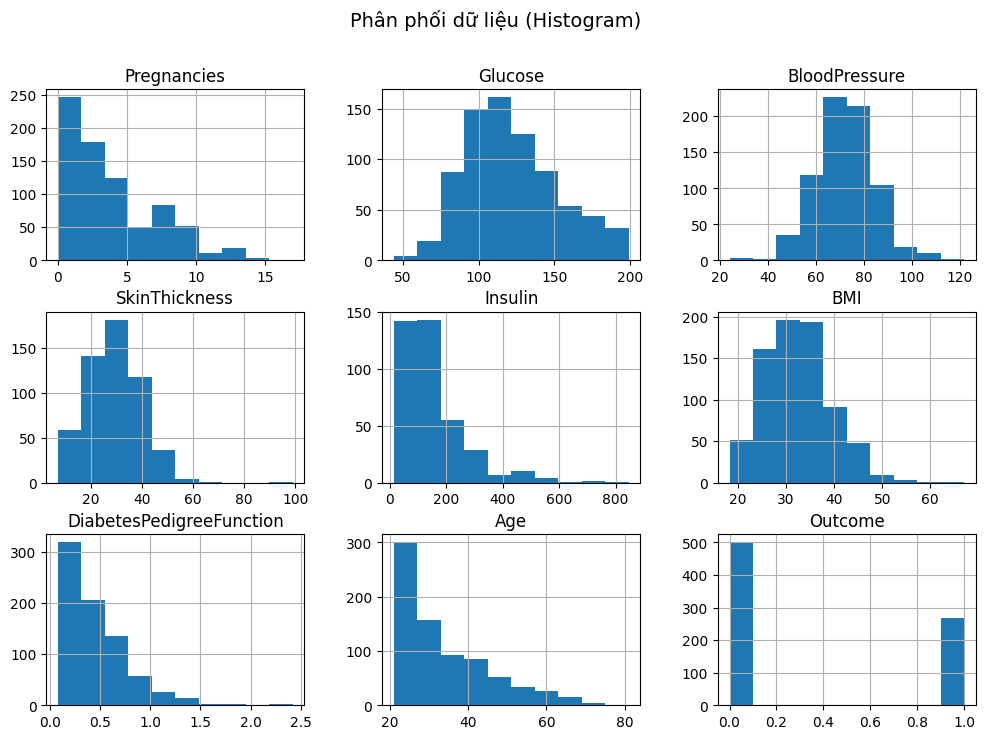

In [15]:
# Boxplot cho các biến định lượng
plt.figure(figsize=(12,8))
data.boxplot(column=['Glucose','BloodPressure','SkinThickness','Insulin','BMI'])
plt.title("Biểu đồ Boxplot các biến định lượng")
plt.show()

# Histogram
data.hist(figsize=(12,8))
plt.suptitle("Phân phối dữ liệu (Histogram)", fontsize=14)
plt.show()


